In [1]:
import warnings
import os
from glob import glob
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
from scipy.stats import norm
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv1D, Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
import keras
from skimage.transform import resize
from PIL import Image

import sys, os
from vae_tools import plot_model, layers, nb_tools, viz, loader, build_model, sanity, sampling, custom_variational_layer, mmvae
import vae_tools
import vae_tools.callbacks
sanity.check()


Using TensorFlow backend.


python version:  3.5.2
keras version: 2.2.4
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Load the data
steps_around_center, angles_around_center = loader.get_steps_around_hokuyo_center(degree_around_center = 80.)
image_rows_cols_chns = (64, 64, 2)
image_original_rows_cols_chns= (800,800,3)
new_shape = image_rows_cols_chns
old_shape = image_original_rows_cols_chns
measurements_per_file = 111 # 2018-06-02 dataset
measurements_per_file = 300 # 2018-06-05 dataset
# folder = glob('2018-06-02/cyl_r*/') + glob('2018-06-02/box_r*/');
# folder = glob('2018-06-05/cyl_r*/') + glob('2018-06-05/box_r*/') + glob('2018-06-05/cyl_g*/');
folder = ('../../mVAE/2018-06-05/cyl_r*/', '../../mVAE/2018-06-05/box_r*/', '../../mVAE/2018-06-05/cyl_g*/');
X_l, X_c, X_set_label_idx, X_set_label_str = loader.camera_lidar("./Xl-80deg_Xc-64-64-2", folder, 
                    "_amiro1_sync_front_camera_image_raw-X-pixeldata.npz", 
                    "_amiro1_sync_laser_scan-X-ranges_intensities_angles.npz", 
                    measurements_per_file, old_shape, new_shape, 683, steps_around_center, 5., overwrite = False)

In [3]:
def get_lidar_mask(X_set, original_dim, empty_perc = 1.0):
    # Prepare mask to remove all data where the objects are to small (to avoid learning empty measurements) (100% i.e. take everything)
    mask = np.ones((len(X_set),), dtype=np.bool)
    for idx in np.arange(len(X_set)):
        if np.sum(X_set[idx,:] == 0.0) / original_dim > empty_perc:
            mask[idx] = False
    return mask

def get_camera_mask(X_set, original_dim, empty_perc = 0.70):
    # Prepare the mask for removing all data which has a certain amount of empty space (to avoid learning empty images)
    empty_perc = 0.70
    mask = np.ones((len(X_set),), dtype=np.bool)
    for idx in np.arange(len(X_set)):
        if np.sum(X_set[idx,:] == 0.0) / original_dim > empty_perc:
            mask[idx] = False
    return mask

def get_lidar_data(X_l, X_set_label_idx, original_dim, use_conv, mask = None, X_set_random_idx = None, X_train_size = None):
    # Data normalization
    X_set = np.copy(X_l)
    X_set = X_set / np.amax(X_set)
    X_set_label = np.copy(X_set_label_idx)
    if mask is None:
        mask = get_lidar_mask(X_set, original_dim, empty_perc = 1.0)

    # normalization (min-0/max-1 and signal spreading)
    if True:
        for idx in np.arange(len(X_set)):
            min_val = np.amin(X_set[idx,X_set[idx,:] != 0.0])
            X_set[idx,X_set[idx,:] != 0.0] = X_set[idx,X_set[idx,:] != 0.0] - min_val
            max_val = np.amax(X_set[idx,:])
            X_set[idx,:] = X_set[idx,:] / max_val
            #
            X_set_val = X_set[idx,X_set[idx,:] != 0.0]
            num_values = len(X_set_val)
            idx_interp = np.linspace(0, num_values, num=227, endpoint=True) 
            idx_orig = np.linspace(0, num_values, num=num_values, endpoint=True)
            X_set[idx,:] = np.interp(idx_interp, idx_orig, X_set_val)

    # Shape for the input
    if use_conv:
        # remove the last value to make the number of measurements even
        X_set = X_set[:,:-1]
        # Add extra dimension
        X_set = np.expand_dims(X_set, axis=-1)

    # Remove unwanted the data
    X_set = X_set[mask,:]
    X_set_label = X_set_label[mask]

    # Get training and test set
    if X_set_random_idx is None:
        X_set_random_idx = np.arange(X_set.shape[0])
        np.random.shuffle(X_set_random_idx)
    if X_train_size is None:
        X_train_size = np.int(len(X_set) * 0.99)
    X_train = X_set[X_set_random_idx[:X_train_size],:]
    X_test = X_set[X_set_random_idx[X_train_size:],:]
    X_train_label = X_set_label[X_set_random_idx[:X_train_size]]
    X_test_label = X_set_label[X_set_random_idx[X_train_size:]]
    # Check normalization
    print("Minimum value: " + str(np.amin(X_set)))
    print("Maximum value: " + str(np.amax(X_set)))
    return X_train, X_test, X_train_label, X_test_label

def get_camera_data(X_c, X_set_label_idx, original_dim, use_conv, mask = None, X_set_random_idx = None, X_train_size = None):
    # Format the data for training
    X_set_label = np.copy(X_set_label_idx)
    X_set = np.reshape(np.copy(X_c), (len(X_c), image_rows_cols_chns[0], image_rows_cols_chns[1], image_rows_cols_chns[2]))
    X_set = 1. - X_set # Invert the brightness
    ## Normalize: Threshold uninformative (< 0.5 = 0), max=1
    X_set[X_set < 0.5] = 0
    X_set = X_set / np.amax(X_set)
    # Copy the upper half of the image to the lower one, to fill the floor with the object as well (to get more information)
    for idx in np.arange(len(X_set)):
        X_set[idx,int(new_shape[0]/2):,:,:] = np.flipud(X_set[idx,:int(new_shape[0]/2),:,:])

    if mask is None:
        mask = get_camera_mask(X_set, original_dim, empty_perc = 0.70)

    # Flatten the data if we do not use conv layers
    if not use_conv:
        X_set = X_set.reshape(-1,np.prod(image_rows_cols_chns))
    # Check normalization
    print("Minimum value: " + str(np.amin(X_set)))
    print("Maximum value: " + str(np.amax(X_set)))

    # Remove
    X_set = X_set[mask,:]
    X_set_label = X_set_label[mask]


    # define train and test set
    if X_set_random_idx is None:
        X_set_random_idx = np.arange(X_set.shape[0])
        np.random.shuffle(X_set_random_idx)
    if X_train_size is None:
        X_train_size = np.int(len(X_set) * 0.99)
    X_train = X_set[X_set_random_idx[:X_train_size],:]
    X_test = X_set[X_set_random_idx[X_train_size:],:]
    X_train_label = X_set_label[X_set_random_idx[:X_train_size]]
    X_test_label = X_set_label[X_set_random_idx[X_train_size:]]

    return X_train, X_test, X_train_label, X_test_label

def get_data(X_c, X_l, X_set_label_idx, original_dim_lidar, original_dim_camera, use_conv_lidar, use_conv_camera):
    mask = np.logical_and(get_camera_mask(X_c, original_dim_camera, empty_perc = 0.70), get_lidar_mask(X_l, original_dim_lidar, empty_perc = 1.0))
    num_samples = np.sum(mask)
    X_set_random_idx = np.arange(num_samples) #  no randomnes
    np.random.shuffle(X_set_random_idx)
    X_train_size = np.int(num_samples * 0.99)
    X_c_train, X_c_test, X_c_train_label, X_c_test_label = get_camera_data(X_c, X_set_label_idx, original_dim_camera, use_conv_camera, mask = mask, X_set_random_idx = X_set_random_idx, X_train_size = X_train_size)
    X_l_train, X_l_test, _, _ = get_lidar_data(X_l, X_set_label_idx, original_dim_lidar, use_conv_lidar, mask = mask, X_set_random_idx = X_set_random_idx, X_train_size = X_train_size)
    return X_l_train, X_l_test, X_c_train, X_c_test, X_c_train_label, X_c_test_label


In [4]:
use_conv_camera = True
use_conv_lidar = False
image_rows_cols_chns = (64, 64, 2)
original_dim_camera = np.prod(image_rows_cols_chns)
if use_conv_lidar:
    original_dim_lidar = 226
else:
    original_dim_lidar = 227
latent_dim = 2
#model_lidar, use_conv_lidar = vae_lidar(train = True, use_conv = True, epochs = 10)
#model_camera,use_conv_camera = vae_camera(train = True, use_conv = True, epochs = 10)
X_l_train, X_l_test, X_c_train, X_c_test, X_train_label, X_test_label = get_data(X_c, X_l, X_set_label_idx, original_dim_lidar, original_dim_camera, use_conv_lidar, use_conv_camera)

encoder_lidar_mean = vae_tools.mmvae.MmVae.load_model(name = "/tmp/vae_lidar_mean")
encoder_lidar_logvar = vae_tools.mmvae.MmVae.load_model(name = "/tmp/vae_lidar_logvar")
encoder_camera_mean = vae_tools.mmvae.MmVae.load_model(name = "/tmp/vae_camera_mean")
encoder_camera_logvar = vae_tools.mmvae.MmVae.load_model(name = "/tmp/vae_camera_logvar")

data = [ encoder_lidar_mean.predict(X_l_train), encoder_camera_mean.predict(X_c_train)]
data_test = [ encoder_lidar_mean.predict(X_l_test), encoder_camera_mean.predict(X_c_test)]


Minimum value: 0.0
Maximum value: 1.0
Minimum value: 6.7945444e-07
Maximum value: 1.0
Loaded model /tmp/vae_lidar_mean from disk
Loaded model /tmp/vae_lidar_logvar from disk
Loaded model /tmp/vae_camera_mean from disk
Loaded model /tmp/vae_camera_logvar from disk


(64, 64, 2)


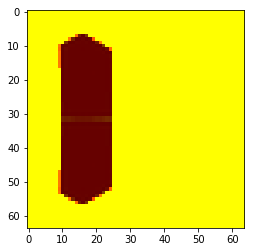

In [5]:
print(X_c_train[1].shape)
image =X_c_train[1]
image = (255. - np.concatenate((image, np.ones((image.shape[1],image.shape[0],1))), axis=2) * 255.) / 255.
plt.imshow(image)

(8910, 2)


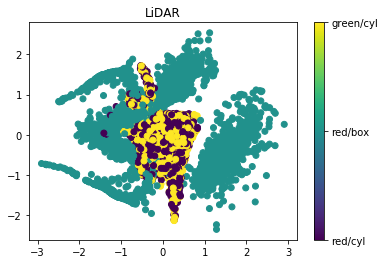

(8910, 2)


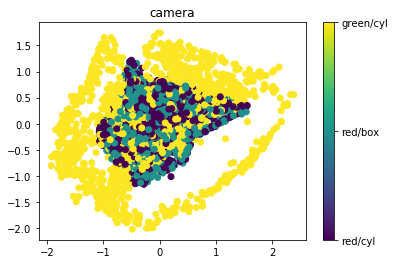

[-1.5843682   0.8512745  -0.32312906 ... -0.31664073  0.50374687
  0.09858257]


In [20]:
import  vae_tools.data_manipulation
data = [ encoder_lidar_mean.predict(X_l_train), encoder_camera_mean.predict(X_c_train)]
data_test = [ encoder_lidar_mean.predict(X_l_test), encoder_camera_mean.predict(X_c_test)]
#data[0] = vae_tools.data_manipulation.norm_min0_max1(data[0].T).T
#data[1] = vae_tools.data_manipulation.norm_min0_max1(data[1].T).T


idx = 0
print(data[idx].shape)
plt.scatter(data[idx][:,0], data[idx][:,1], c = X_train_label)
plt.title("LiDAR")
cbar = plt.colorbar(ticks=[0, 1, 2]).ax.set_yticklabels(['red/cyl', 'red/box', 'green/cyl'])
plt.show()
idx = 1
print(data[idx].shape)
plt.scatter(data[idx][:,0], data[idx][:,1], c = X_train_label)
plt.title("camera")
cbar = plt.colorbar(ticks=[0, 1, 2]).ax.set_yticklabels(['red/cyl', 'red/box', 'green/cyl'])
plt.show()

print(data[idx][:,0])

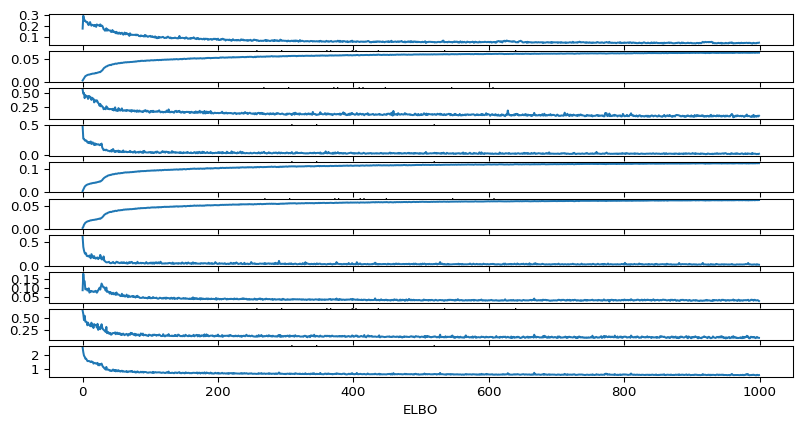

In [7]:
import vae_tools
from importlib import reload
reload(vae_tools)
reload(vae_tools.mmvae)

# Multi modal training of proprio and voxel
model_name = "lidar_camera_vae"
store_model = True # Train and store the model if "True" or loads existing models if "False"
store_model_overwrite = False # Overwrite model if it exists
store_model_prefix = "models/lidar_camera" # prefix for loading and storing
if store_model:

    batch_size = 128
    epochs = 1000
    z_dim = 2
    beta = 0.01
    beta_is_normalized = True
    original_dim = 2
    intermediate_dim = 256 # 128 # 64
    intermediate_dim_2 = 64 #int(intermediate_dim / 2)
    epsilon_std = 1.
    
    # latent_encoder = vae_tools.mmvae.LatentEncoder(layer_dimensions = [64, 32], is_relative = [False, False], activations = ['relu', 'relu'])
    # latent_encoder = vae_tools.mmvae.LatentEncoder(layer_dimensions = [intermediate_dim_2], is_relative = [False], activations = ['relu'])
    latent_encoder = vae_tools.mmvae.LatentEncoder(layer_dimensions = [intermediate_dim_2, intermediate_dim_2], is_relative = [False, False], activations = ['relu', 'relu'])

    encoder_pv = [[
            Input(shape=(original_dim,)),
            Dense(intermediate_dim, activation='relu'),
            #keras.layers.Dropout(0.5),
            Dense(intermediate_dim_2, activation='relu'),
            #keras.layers.Dropout(0.5)
        ],[
            Input(shape=(original_dim,)),
            Dense(intermediate_dim, activation='relu'),
            #keras.layers.Dropout(0.5),
            Dense(intermediate_dim_2, activation='relu'),
            #keras.layers.Dropout(0.5)
        ]]
    decoder_pv = [[
            Dense(intermediate_dim_2, activation='relu'),
            #keras.layers.Dropout(0.5),
            Dense(intermediate_dim, activation='relu'),
            #keras.layers.Dropout(0.5),
            Dense(original_dim, activation='linear') # should be linear and not sigmoid, because we actually do regresion
        ],[
            Dense(intermediate_dim_2, activation='relu'),
            #keras.layers.Dropout(0.5),
            Dense(intermediate_dim, activation='relu'),
            #keras.layers.Dropout(0.5),
            Dense(original_dim, activation='linear') # should be linear and not sigmoid, because we actually do regresion
        ]]

    vae_obj = vae_tools.mmvae.MmVae(z_dim, encoder_pv, decoder_pv, [2, 2], beta, beta_is_normalized = beta_is_normalized, latent_encoder = latent_encoder,
                                    reconstruction_loss_metrics = [vae_tools.mmvae.ReconstructionLoss.MSE], name=model_name)

    vae = vae_obj.get_model()
    vae.compile(optimizer='adam', loss=None)
    #vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
    # Store the losses, encodings, and decodings to tensorboard
    losses_cb = vae_tools.callbacks.Losses(data = data_test)
    # Train
    vae.fit(data, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=None, verbose = 0, callbacks=[losses_cb])
    # Show the losses
    try:
        vae_tools.viz.plot_losses(losses_cb, plot_elbo = True)
    except:
        pass
   # Get the models
    encoder_input = [encoder_pv[0][0], encoder_pv[1][0]]
    encoder_mean = [vae_obj.get_encoder_mean([encoder_input[0]]),
                                 vae_obj.get_encoder_mean([encoder_input[1]]),
                                 vae_obj.get_encoder_mean(encoder_input)]
    encoder_logvar = [vae_obj.get_encoder_logvar([encoder_input[0]]),
                                   vae_obj.get_encoder_logvar([encoder_input[1]]),
                                   vae_obj.get_encoder_logvar(encoder_input)]
    
    # Store model
    #vae_obj.store_model(name = store_model_prefix + "_" + model_name + "_dec", model = vae_obj.get_decoder(), overwrite = store_model_overwrite)
    vae_obj.store_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_mean_ProprioVoxel",
                                 model_inputs = encoder_input,
                                 get_model_callback = vae_obj.get_encoder_mean, overwrite = store_model_overwrite)
    vae_obj.store_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_logvar_ProprioVoxel",
                                 model_inputs = encoder_input,
                                 get_model_callback = vae_obj.get_encoder_logvar, overwrite = store_model_overwrite)
else:
    # Load the models
    #decoder_mean = MmVae.load_model(name = store_model_prefix + "_" + model_name + "_dec")
    encoder_mean, _ =  vae_tools.mmvae.MmVae.load_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_mean_ProprioVoxel",
                                             num_elements = 2)
    encoder_logvar, _ =  vae_tools.mmvae.MmVae.load_model_powerset(prefix = store_model_prefix + "_" + model_name + "_enc_logvar_ProprioVoxel",
                                               num_elements = 2)



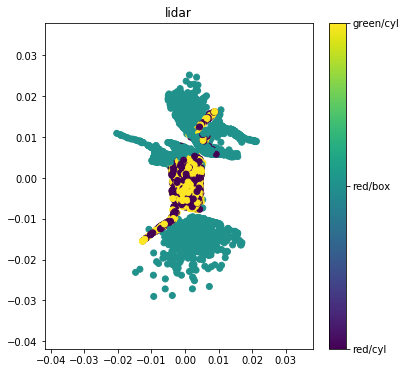

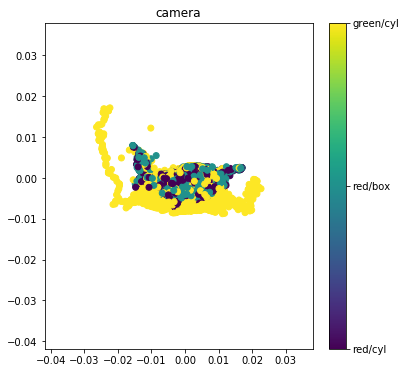

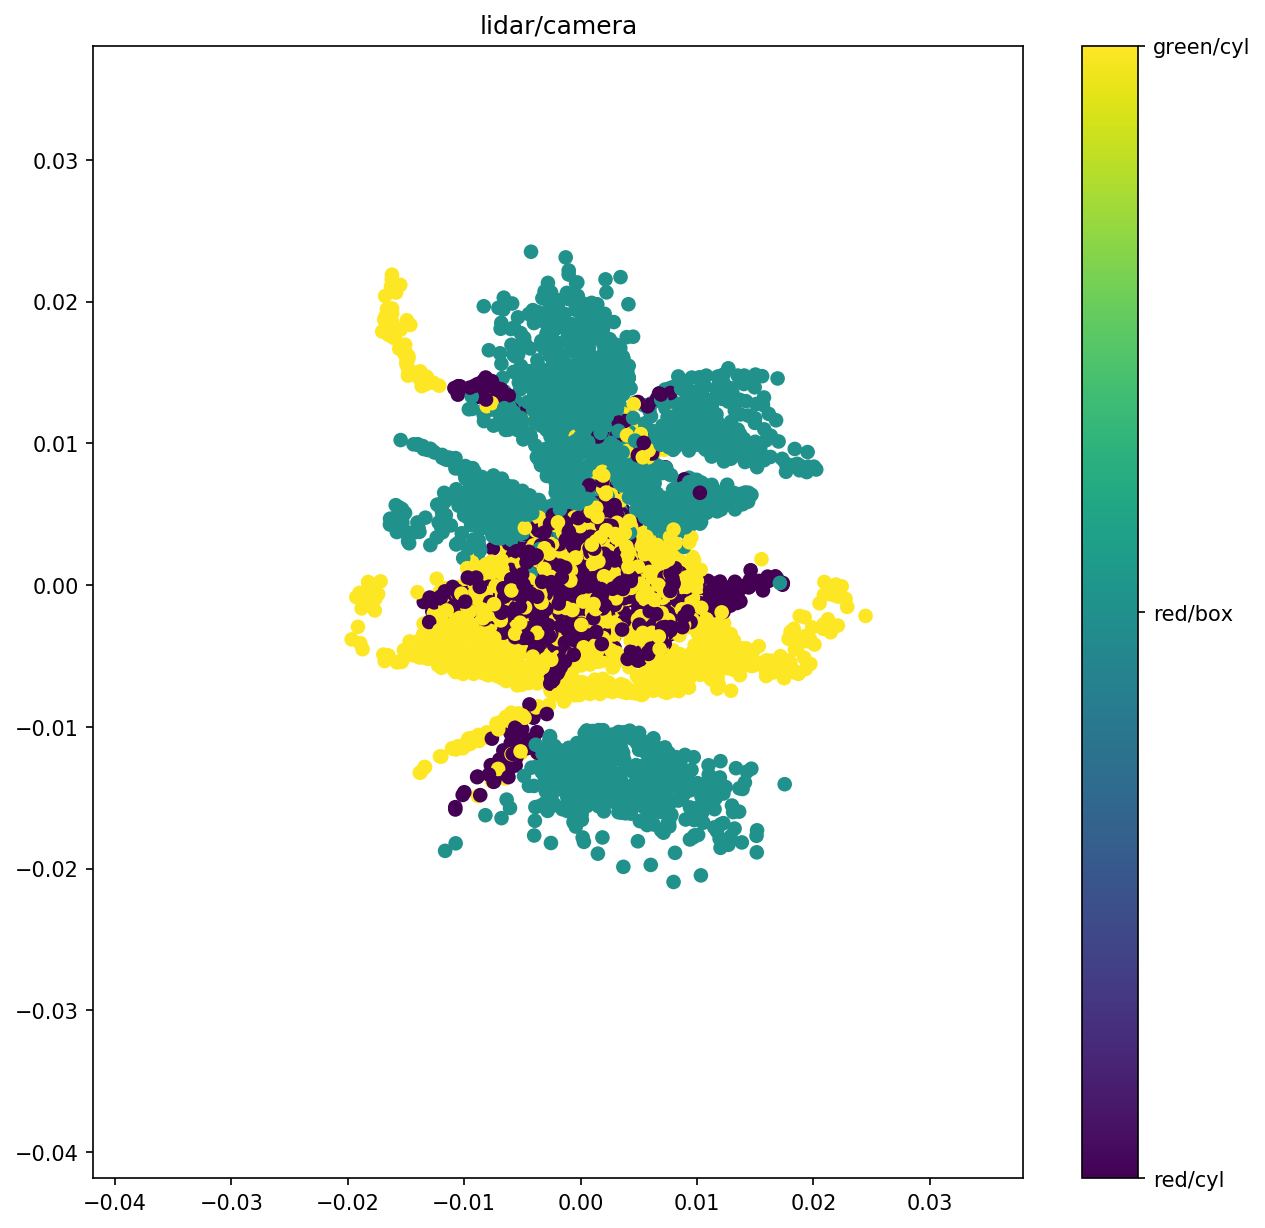

In [26]:
import vae_tools
from importlib import reload
reload(vae_tools.viz)

mean_encoded = vae_obj.get_encoder_mean([encoder_pv[0][0]]).predict(data[0])
_, ax1 = vae_tools.viz.plot_embedding(mean_encoded, X_train_label, figsize=(6, 6), colormap=None, show_ticks = True)
#plt.axis("equal")
plt.colorbar(ax=ax1, ticks=[0, .5, 1.]).ax.set_yticklabels(['red/cyl', 'red/box', 'green/cyl'])
ax1.set_title("lidar")

mean_encoded = vae_obj.get_encoder_mean([encoder_pv[1][0]]).predict(data[1])
_, ax2 = vae_tools.viz.plot_embedding(mean_encoded, X_train_label, figsize=(6, 6), colormap=None, show_ticks = True)
#plt.axis("equal")
plt.colorbar(ax=ax2, ticks=[0, .5, 1.]).ax.set_yticklabels(['red/cyl', 'red/box', 'green/cyl'])
ax2.set_title("camera")

# Plot the embedding proprio and voxel
mean_encoded = vae_obj.get_encoder_mean([encoder_pv[0][0], encoder_pv[1][0]]).predict(data)
#var_encoded = np.sum(np.exp(encoder_logvar[2].predict(data, batch_size=batch_size)),axis=-1) # trace of co-variance
#vae_tools.viz.plot_embedding(mean_encoded, var_encoded, colormap="rainbow", figsize=(6, 6))
#plt.colorbar()
_, ax3 = vae_tools.viz.plot_embedding(mean_encoded, X_train_label, figsize=(10, 10), colormap=None, show_ticks = True, dpi=150)
#plt.axis("equal")
plt.colorbar(ax=ax3, ticks=[0, .5, 1.]).ax.set_yticklabels(['red/cyl', 'red/box', 'green/cyl'])
ax3.set_title("lidar/camera")

grid_min, grid_max = vae_tools.viz.set_xy_equal_lim([ax1, ax2, ax3])

plt.show()

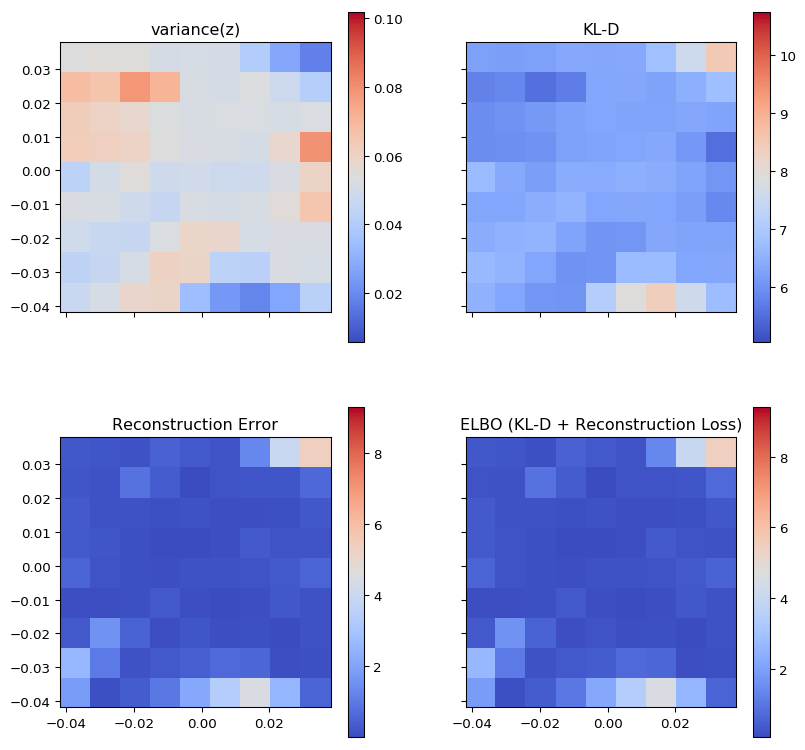

In [9]:
import vae_tools
import vae_tools.viz
from importlib import reload
reload(vae_tools.viz)
# Get statistics
idx = 1
decoder_model = vae_obj.get_decoder(decoder_output_list = [decoder_pv[idx][-1]])
encoder_mean = vae_obj.get_encoder_mean([encoder_pv[idx][0]])
encoder_logvar = vae_obj.get_encoder_logvar([encoder_pv[idx][0]])

_beta = beta
if beta_is_normalized:
    _beta = vae_tools.mmvae.MmVae.get_unnormalized_beta(_beta, original_dim, z_dim)

#x_var_encoded, x_kld_encoded, x_elbo_encoded, x_reconstruction_encoded, grid_x, grid_y = vae_tools.viz.get_latent_space_statistics(decoder_model, encoder_mean, encoder_logvar, encoder_decoder = None, grid_min = grid_min, grid_max = grid_max)
stat_var, stat_kld, stat_elbo, stat_reconstruction, grid_x, grid_y, z_inputs, z_reencodings = \
    vae_tools.viz.get_latent_space_statistics(decoder_model, encoder_mean, encoder_logvar, encoder_decoder = None, grid_min = grid_min, grid_max = grid_max, beta = _beta, steps = 10)
# grid_min = norm.ppf(0.01), grid_max = norm.ppf(0.99)
# Plot them
X, Y = np.meshgrid(grid_x, grid_y)
f, axs = vae_tools.viz.plot_latent_statistics (X,Y,stat_var, stat_kld, stat_reconstruction, stat_elbo)

In [10]:
idx_sample = 2
print(X_train_label[idx_sample]) # 0: only lidar&camera (idx 0&1), 1: only lidar (idx 0), 2: only camera (idx 1)
idx = 0
encoder_logvar = np.exp(vae_obj.get_encoder_logvar([encoder_pv[idx][0]]).predict(data[idx][[idx_sample]]))
print(encoder_logvar)
idx = 1
encoder_logvar = np.exp(vae_obj.get_encoder_logvar([encoder_pv[idx][0]]).predict(data[idx][[idx_sample]]))
print(encoder_logvar)
idx = 2
encoder_logvar = np.exp(vae_obj.get_encoder_logvar([encoder_pv[0][0], encoder_pv[1][0]]).predict([data[0][[idx_sample]], data[1][[idx_sample]]]))
print(encoder_logvar)

2
[[0.00069027 0.00058983]]
[[0.00066647 0.00060304]]
[[0.00066923 0.00058577]]


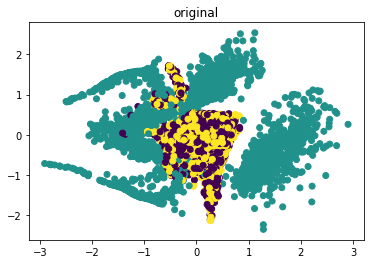

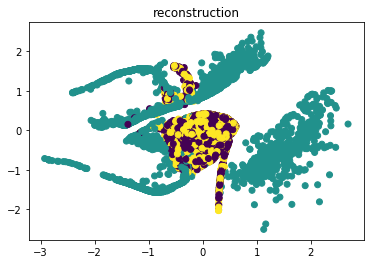

In [11]:
idx = 0
decoder_model = vae_obj.get_decoder(decoder_output_list = [decoder_pv[idx][-1]])
encoder_mean = vae_obj.get_encoder_mean([encoder_pv[idx][0]])
encoder_logvar = vae_obj.get_encoder_logvar([encoder_pv[idx][0]])

data_decoded = decoder_model.predict(encoder_mean.predict(data[idx]))

plt.scatter(data[idx][:,0], data[idx][:,1], c=X_train_label)
plt.title("original")
plt.show()
plt.scatter(data_decoded[:,0], data_decoded[:,1], c=X_train_label)
plt.title("reconstruction")
plt.show()

(9000, 227)


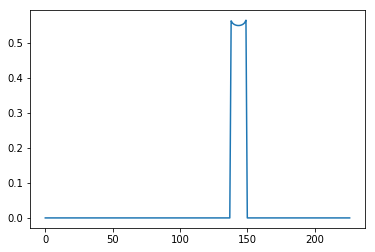

ValueError: cannot reshape array of size 2 into shape (64,64,2)

In [12]:
idx = 14
print(X_l.shape)
plt.plot(X_l[idx])
#plt.plot(data[0][idx])
plt.show()
image = data[1][idx]
if len(image.shape) == 1:
    image = np.matlib.reshape(image, (64,64,2))
image = (255. - np.concatenate((image, np.ones((image.shape[1],image.shape[0],1))), axis=2) * 255.) / 255.
plt.imshow(image)

In [ ]:
model_idx = 0 # 0:lidar, 1: camera
X_train = data[model_idx]
encoder = encoder_mean[model_idx]
encoder_lv = encoder_logvar[model_idx]
if model_idx == 0:
    decoder = vae_obj.get_decoder(decoder_output_list = [model_lidar.decoder[0][-1]])
else:
    decoder = vae_obj.get_decoder(decoder_output_list = [model_camera.decoder[0][-1]])

# Vizualization
# Encode samples to get the min and max values in latent space
X_encoded = encoder.predict(X_train, batch_size=batch_size)

# Plot in- and output signals
if model_idx == 0:
    viz.lidar_in_out_2(X_train, 16, encoder, decoder)

# display a 2D manifold
nx = 50
ny = 50

# Chose linearly spaced coordinates according to the above figure
grid_x = (np.linspace(np.min(X_encoded[:, 0]), np.max(X_encoded[:, 0]), nx))
grid_y = (np.linspace(np.min(X_encoded[:, 1]), np.max(X_encoded[:, 1]), ny))
grid_x = norm.ppf(np.linspace(0.001, 0.999, nx))
grid_y = norm.ppf(np.linspace(0.001, 0.999, ny))
grid_x = np.linspace(np.amin(grid_x), np.amax(grid_x), nx)
grid_y = np.linspace(np.amin(grid_y), np.amax(grid_y), ny)

# Project input to latent space
viz.scatter_encoder_2(X_train, X_train_label, grid_x, grid_y, encoder, figsize=(15, 15), dpi=150)

# Plot the resampled inputs
if model_idx == 0:
    figures, z_reencoded_mean, z_reencoded_std = viz.get_lidar_dec_enc_samples_2(grid_x, grid_y, encoder, encoder_lv, decoder, Dz = 2)
    plt.show()
else:
    figure, z_reencoded_mean, z_reencoded_std = viz.get_image_dec_enc_samples_2(grid_x, grid_y, encoder, encoder_lv, decoder, Dz = 2, image_size = image_rows_cols_chns)
    plt.figure(figsize=(15, 15), dpi=96)
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

# Plot the resampled std deviations
X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
plt.pcolor(X, Y, z_reencoded_std, cmap='coolwarm', vmin=z_reencoded_std.min(), vmax=z_reencoded_std.max())
plt.colorbar()
plt.axis("image")
plt.show()